In [1]:
import sympy as sp 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const

# Spherical case
Try to show that the longest eigen vector of the tidal tensor will always align with the radial vector 

In [2]:
# Variables
x, y, z, G, M = sp.symbols('x y z G M')
r = sp.sqrt(x**2 + y**2 + z**2)

# Potential
Phi = -G*M/r

# Force = grad(Phi)
grad_Phi = [sp.diff(Phi, var) for var in (x, y, z)]

# Hessian (tidal tensor)
tidal_tensor = -sp.Matrix([
    [sp.diff(grad_Phi[i], var) for var in (x, y, z)]
    for i in range(3)
])

tidal_tensor

Matrix([
[3*G*M*x**2/(x**2 + y**2 + z**2)**(5/2) - G*M/(x**2 + y**2 + z**2)**(3/2),                                    3*G*M*x*y/(x**2 + y**2 + z**2)**(5/2),                                    3*G*M*x*z/(x**2 + y**2 + z**2)**(5/2)],
[                                   3*G*M*x*y/(x**2 + y**2 + z**2)**(5/2), 3*G*M*y**2/(x**2 + y**2 + z**2)**(5/2) - G*M/(x**2 + y**2 + z**2)**(3/2),                                    3*G*M*y*z/(x**2 + y**2 + z**2)**(5/2)],
[                                   3*G*M*x*z/(x**2 + y**2 + z**2)**(5/2),                                    3*G*M*y*z/(x**2 + y**2 + z**2)**(5/2), 3*G*M*z**2/(x**2 + y**2 + z**2)**(5/2) - G*M/(x**2 + y**2 + z**2)**(3/2)]])

Note that sympy is having a hard time doing all the algebraic manipulations, like finding the eigen vectors. I will simplify this expression to find the tidal tensor. This can be done by replacing $x^2 + y^2 + z^2$ with $r^2$ and factoring out  $\frac{GM}{r^3}$ This way, I can have a "scaled" tidal tensor.

Note that below I introduce $r$ without establishing that it is $r^2=x^2 + y^2 + z^2$. With SymPy, this manouver keeps the equation neat and orderly. 

In [3]:
r,x,y,z=sp.symbols('r x y z', real=True)
T = -sp.Matrix(
    [1 - 3*x**2/r**2, 
     -3*x*y/r**2, 
     -3*x*z/r**2,
     -3*x*y/r**2,
     1 - 3*y**2/r**2,
     -3*y*z/r**2,
     -3*x*z/r**2,
     -3*y*z/r**2,
     1 - 3*z**2/r**2]
)
scaled_tidal_tensor=T.reshape(3,3)


Now create numpy functions from sympy 

In [4]:
scaled_tidal_tensor_func = sp.lambdify((r, x, y, z), scaled_tidal_tensor, "numpy")

## Play with the tidal field for the moon

There are many ways that the moon and the tides play together. The tides from the earth deform the shape of the moon, and thus the moon is tidally locked. The tides from the moon "fix" the Earth's water in an ellipse as the earth then moves around it. But, I want to know how much the moons orbit could deviate given the tidal field of the sun. 

Things to consider 
- The Earth has a non intertial reference frame as it orbits the sun 
- the moon-earth distance
- the gravitational strength of the earth
- the solar tidal field 

I want to compute the orbits of the moon by continually adding more corrections: 
1. The two body problem 
2. The tidal froces from the sun while in the earth's reference frame. 


Q. What is stronger? the tidal force or the centrigufal force? I wonder! 

In [37]:
# pick the units
unitL = u.au
unitT = u.yr
unitV = unitL / unitT
unitM = u.Msun
unitG=unitV**2 * unitL / unitM
G_val=const.G.to(unitG)
# Pick some values 
Msun = 1*u.Msun
Mearth= (1*u.Mearth).to(u.Msun)
Dearth= 1*u.au
Dmoon = 384400 * u.km # from google 
Dmoon = Dmoon.to(u.au)
omega = 2*np.pi / (1 * u.yr)
# drop the units 
Msun = Msun.value
Mearth = Mearth.value
Dearth = Dearth.value
Dmoon = Dmoon.value
omega = omega.value
G_val = G_val.value
# numerical parametesr 
npoints = 25

In [38]:
# pick a position of the earth 
time = 0.1
x_earth = Dearth * np.cos(omega * time)
y_earth = Dearth * np.sin(omega * time)
z_earth = 0
r_earth = np.sqrt(x_earth**2 + y_earth**2 + z_earth**2)
# eval the tidal tensor at the position of the earth
unscaled_tidal_tensor=scaled_tidal_tensor_func(r_earth, x_earth, y_earth, z_earth)
# scale the tidal tensor
tidal_tensor = unscaled_tidal_tensor * (G_val * Msun / Dearth**3)
# get the eigen vectors of the tidal tensor
unscaled_eigen = np.linalg.eig(unscaled_tidal_tensor)
eigen = np.linalg.eig(tidal_tensor)

In [39]:
# create a unit sphere 
npoints = 25
x_sphere = Dmoon*np.cos(np.linspace(0, 2 * np.pi, npoints))
y_sphere = Dmoon*np.sin(np.linspace(0, 2 * np.pi, npoints))
# scale them based on the eigenvalues
scaled_eigen = np.sqrt(np.abs(unscaled_eigen.eigenvalues))
x_sphere = scaled_eigen[0] * x_sphere
y_sphere = scaled_eigen[1] * y_sphere
# rotate the sphere based on the eigenvectors
surface_points = np.vstack([x_sphere.ravel(), y_sphere.ravel(), np.zeros_like(x_sphere.ravel())])
# rotate the points using the rotation matrix
rotation_matrix = np.array(unscaled_eigen.eigenvectors)  # Transpose to match the correct rotation convention
rotated_points = rotation_matrix.dot(surface_points)

In [73]:
# set the grid to evaulate the tidal forces around the earth
delta = 2*Dmoon
xs = np.linspace(-delta, delta, npoints)
ys = np.linspace(-delta, delta, npoints)
X, Y = np.meshgrid(xs, ys)
# prepare the vector outputs 
tidal_vectors = np.zeros((X.shape[0], X.shape[1], 3))  # For storing vectors
# make a list of coordinates
coords = np.zeros((3,X.flatten().shape[0]))
# fill in the coordinates
coords[0] = X.flatten()
coords[1] = Y.flatten()
coords[2] = np.zeros_like(X.flatten())
# compute the dot product 
tidal_force_vectors=tidal_tensor.dot(coords)
# Normalize the vectors
tidal_force_magnitude=np.linalg.norm(tidal_force_vectors, axis=0)
normalized_tidal_forces = tidal_force_vectors / tidal_force_magnitude
# compute the force from the earth 
distance_to_earth = np.sum(coords**2, axis=0)**0.5
earth_force_magnitude = (G_val*Mearth) * (1/distance_to_earth**2)
earth_force = -coords * earth_force_magnitude / distance_to_earth
normalized_earth_force = earth_force / earth_force_magnitude

# make the field for the centrifugal force

omega_vec = np.array([0, 0, omega])
centrifugalforce=-np.cross(omega_vec,np.cross(omega_vec.T, coords.T)).T
centrifugalforce_magnitude = np.linalg.norm(centrifugalforce, axis=0)
# Normalize the vectors
normalized_centrifugalforce = centrifugalforce / centrifugalforce_magnitude


# make the net force vector 
net_force = tidal_force_vectors + earth_force + centrifugalforce
# normalize each of them 
norm_net_force = np.linalg.norm(net_force, axis=0)
normalized_net_force = net_force / norm_net_force

/var/folders/vt/72vlp8hj577dnzr1gl35j41c0000gn/T/ipykernel_60598/4025443617.py:18: RuntimeWarning: invalid value encountered in divide
  normalized_tidal_forces = tidal_force_vectors / tidal_force_magnitude
/var/folders/vt/72vlp8hj577dnzr1gl35j41c0000gn/T/ipykernel_60598/4025443617.py:21: RuntimeWarning: divide by zero encountered in divide
  earth_force_magnitude = (G_val*Mearth) * (1/distance_to_earth**2)
/var/folders/vt/72vlp8hj577dnzr1gl35j41c0000gn/T/ipykernel_60598/4025443617.py:22: RuntimeWarning: invalid value encountered in multiply
  earth_force = -coords * earth_force_magnitude / distance_to_earth
/var/folders/vt/72vlp8hj577dnzr1gl35j41c0000gn/T/ipykernel_60598/4025443617.py:31: RuntimeWarning: invalid value encountered in divide
  normalized_centrifugalforce = centrifugalforce / centrifugalforce_magnitude


In [83]:
# make a colormap for the magnitude of the force
vmax = 20
vmin = .1
mycmap = mpl.colormaps.get_cmap('rainbow_r')
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)
colors_tidal = [mycmap(norm(force)) for force in tidal_force_magnitude]
colors_earth = mycmap(norm(earth_force_magnitude))
colors_centrifugal = mycmap(norm(centrifugalforce_magnitude))
AXIS={
    "xlim": (x_earth-delta, x_earth+delta),
    "ylim": (y_earth-delta, y_earth+delta),
    "aspect": "equal",
    "xlabel": "X [kpc]",
    "ylabel": "Y [kpc]",}

In [84]:
import matplotlib.font_manager as fm
# Check if the new font is now available
available_fonts = [f.name for f in fm.fontManager.ttflist]
emoji_fonts = [f for f in available_fonts if 'emoji' in f.lower() or 'noto' in f.lower()]
print("Available emoji fonts:", emoji_fonts)
emoji_font = fm.FontProperties(family='Noto Color Emoji')


Available emoji fonts: ['Noto Sans Gothic', 'Noto Serif Myanmar', 'Noto Sans Yi', 'Noto Sans Imperial Aramaic', 'Noto Sans Lycian', 'Noto Sans Modi', 'Noto Sans Khojki', 'Noto Sans Rejang', 'Noto Sans Hatran', 'Noto Sans Saurashtra', 'Noto Sans Bassa Vah', 'Noto Sans Newa', 'Noto Sans Batak', 'Noto Sans Egyptian Hieroglyphs', 'Noto Sans Kannada', 'Noto Sans Osmanya', 'Noto Sans Samaritan', 'Noto Sans Mandaic', 'Noto Sans Linear B', 'Noto Sans Syriac', 'Noto Sans PhagsPa', 'Noto Sans Marchen', 'Noto Sans Bhaiksuki', 'Noto Sans Coptic', 'Noto Sans Tifinagh', 'Noto Sans Linear A', 'Noto Sans Limbu', 'Noto Sans Carian', 'Noto Sans Old Permic', 'Noto Sans Sora Sompeng', 'Noto Sans Syloti Nagri', 'Noto Sans Cuneiform', 'Noto Sans Meroitic', 'Noto Sans Tagalog', 'Noto Serif Balinese', 'Noto Sans Chakma', 'Noto Sans Cham', 'Noto Sans Glagolitic', 'Noto Sans Phoenician', 'Noto Sans Gunjala Gondi', 'Noto Sans Lepcha', 'Noto Sans Mro', 'Noto Sans New Tai Lue', 'Noto Sans Ugaritic', 'Noto Sans Mul

In [85]:
# Add this at the top of your notebook
from matplotlib import offsetbox
from PIL import Image
from urllib.request import urlopen
import io

# Download a small earth image or use a local one
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/cb/The_Blue_Marble_%28remastered%29.jpg/240px-The_Blue_Marble_%28remastered%29.jpg"
img_data = urlopen(url).read()
img = Image.open(io.BytesIO(img_data))

# For your plotting code
earth_img = offsetbox.OffsetImage(img, zoom=0.1)


In [109]:
unitAccel=unitG*unitM/unitL**2

unitAccel.to_string()

'AU / yr2'

In [97]:
unitV/unitT

Unit("AU / yr2")

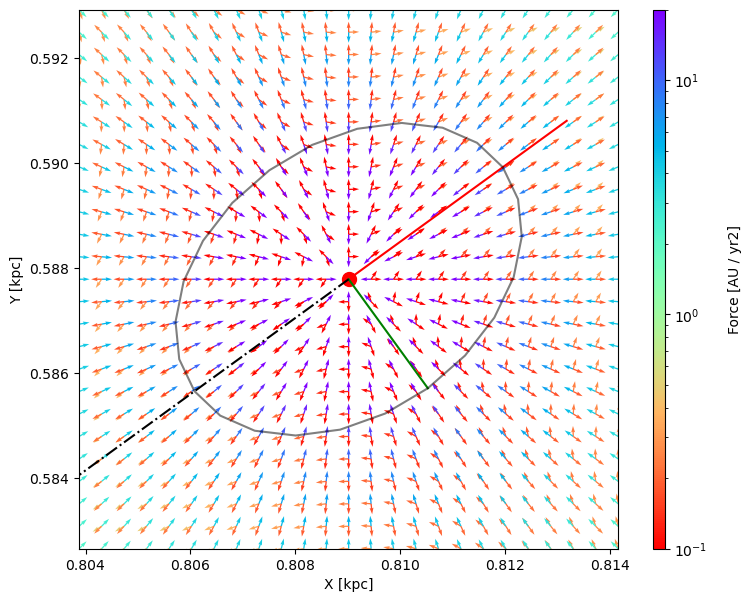

In [113]:
# plot the tidal field about the earth 
fig=plt.figure(figsize=(8, 7))
gs=fig.add_gridspec(1, 2, width_ratios=[1, 1/50],wspace=0)
axis=fig.add_subplot(gs[0, 0])
cax=fig.add_subplot(gs[0, 1])
im=axis.quiver(x_earth+X.flatten(), y_earth+Y.flatten(), normalized_tidal_forces[0], normalized_tidal_forces[1], color=colors_tidal,units="xy",scale=5000  )
axis.quiver(x_earth+X.flatten(), y_earth+Y.flatten(), normalized_earth_force[0], normalized_earth_force[1], color=colors_earth,units="xy",scale=5000  )
axis.quiver(x_earth+X.flatten(), y_earth+Y.flatten(), normalized_centrifugalforce[0], normalized_centrifugalforce[1], color=colors_centrifugal,units="xy",scale=5000  )
axis.scatter(x_earth, y_earth, color='r', s=100)
# add the eigen vectors 
axis.plot([x_earth,x_earth+Dmoon*unscaled_eigen.eigenvalues[0]*unscaled_eigen.eigenvectors[0][0]],[y_earth,y_earth+Dmoon*unscaled_eigen.eigenvalues[0]*unscaled_eigen.eigenvectors[1][0]],'-', color='r')
axis.plot([x_earth,x_earth+Dmoon*unscaled_eigen.eigenvalues[1]*unscaled_eigen.eigenvectors[0][1]],[y_earth,y_earth+Dmoon*unscaled_eigen.eigenvalues[1]*unscaled_eigen.eigenvectors[1][1]],'-', color='g')
axis.plot([x_earth,x_earth+Dmoon*unscaled_eigen.eigenvalues[2]*unscaled_eigen.eigenvectors[2][0]],[y_earth,y_earth+Dmoon*unscaled_eigen.eigenvalues[2]*unscaled_eigen.eigenvectors[2][1]],'-', color='b')

sm=plt.cm.ScalarMappable(cmap=mycmap, norm=norm)
sm.set_array([])  # You need to set an array, even if empty
cbar=fig.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('Force [{:s}]'.format(unitAccel.to_string()), rotation=90, labelpad=15)

# add the eart 
# earth_annotation = offsetbox.AnnotationBbox(earth_img, (x_earth, y_earth), frameon=False)
# axis.add_artist(earth_annotation)

axis.plot([0,x_earth],[0,y_earth],'-.', color='k')
# add the deformed shape 
axis.plot(x_earth+rotated_points[0],y_earth+rotated_points[1], color='k', alpha=0.5)

axis.set(**AXIS);

In [13]:
AXIS2 = {
    "xlim": (-Dearth, Dearth),
    "ylim": (-Dearth, Dearth),
    "aspect": "equal",
    "xlabel": "X [au]",
    "ylabel": "Y [au]",
}

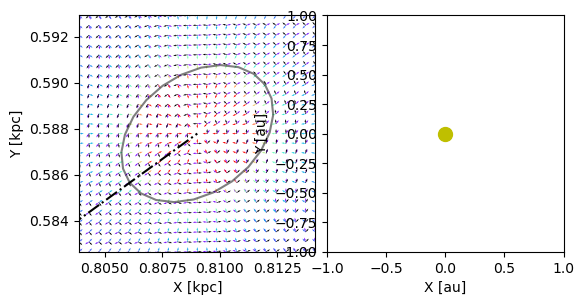

In [14]:
fig=plt.figure(figsize=(8.25-2, (11.75-2)/3))
gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.05)
axis1 = fig.add_subplot(gs[0])
axis2 = fig.add_subplot(gs[1])
axis1.quiver(x_earth+X.flatten(), y_earth+Y.flatten(), normalized_tidal_forces[0], normalized_tidal_forces[1], color=colors_tidal,units="xy",scale=5000  )
axis1.quiver(x_earth+X.flatten(), y_earth+Y.flatten(), normalized_earth_force[0], normalized_earth_force[1], color=colors_earth,units="xy",scale=5000  )
axis1.quiver(x_earth+X.flatten(), y_earth+Y.flatten(), normalized_centrifugalforce[0], normalized_centrifugalforce[1], color='k',units="xy",scale=5000  )
axis1.plot([0,x_earth],[0,y_earth],'-.', color='k')
axis1.set(**AXIS);
axis1.plot(x_earth+rotated_points[0], y_earth+rotated_points[1], color='k', alpha=0.5)
# add the positions 
# axis2.scatter(x_earth, y_earth, color='b', s=10)
axis2.scatter(0,0, color='y', s=100)
axis2.set(**AXIS2);

# Solve the equations of motion 
$$ \ddot{r}_\text{moon,earth} = -\nabla \Phi(r_\text{moon,earth})_{\text{Earth}} - T_\odot(r_\text{earth,sun}) \cdot \vec{r}_\text{moon,earth} - \vec{\omega} \times \left(\vec{\omega} \times {\vec{r}_{\text{moon,sun}}}\right)$$ 

We can use scipy's `solve_ivp`  since orbits are initial value problems of ordinary differential equations. Since I need to evaluate the position of the earth a function of time, the equations of motion will not be a set of autonomous differentia equations. They will depend on time 

In [147]:
from scipy import integrate

In [156]:
r,x,y,z=sp.symbols('r x y z', real=True)
T = -sp.Matrix(
    [1 - 3*x**2/r**2, 
     -3*x*y/r**2, 
     -3*x*z/r**2,
     -3*x*y/r**2,
     1 - 3*y**2/r**2,
     -3*y*z/r**2,
     -3*x*z/r**2,
     -3*y*z/r**2,
     1 - 3*z**2/r**2]
)
scaled_tidal_tensor=T.reshape(3,3)
scaled_tidal_tensor_func = sp.lambdify((r, x, y, z), scaled_tidal_tensor, "numpy")

def system_of_equations(t,y,omega,scaled_tidal_tensor_func):
    # unpack the state of the system 
    position_moon = y[:3]
    velocity_moon = y[3:]

    # get the current position of the earth
    x_earth = Dearth * np.cos(omega * t)
    y_earth = Dearth * np.sin(omega * t)
    z_earth = 0
    position_earth = np.array([x_earth, y_earth, z_earth])
    r_earth = np.linalg.norm(position_earth)
    # eval the tidal tensor at the position of the earth
    tidal_tensor = -(G_val*Msun/r_earth**3)*scaled_tidal_tensor_func(r_earth, position_earth[0], position_earth[1], position_earth[2])
    tidal_force = tidal_tensor.dot(position_moon)
    # evaluate the centrifugal force
    centrifugalforce = - np.cross(omega_vec, np.cross(omega_vec.T, position_moon.T).T)
    # evaluate the force from the earth
    moon_earth_distance = np.linalg.norm(position_moon)
    earth_force=-(G_val*Mearth / moon_earth_distance**3) * position_moon
    # get the net force 
    net_force = tidal_force + centrifugalforce + earth_force
    # stack up everything 
    ydot = np.concatenate([velocity_moon, net_force])
    return ydot

In [ ]:
# pick the initial conditions of the moon w.r.t. the earth
# build the initial conditions of the moon from https://nssdc.gsfc.nasa.gov/planetary/factsheet/moonfact.html
semi_major_axis = 0.3844 * 1e6 * u.km
eccentricity = 0.0549 
inclination = 5.145*u.deg
# convert the units
semi_major_axis=semi_major_axis.to(unitL).value
inclination=inclination.to(u.rad).value
# get the apogee
ra = (1+eccentricity) * semi_major_axis
# get the spped at apogee
v_apogee = np.sqrt(G_val*Mearth * (2/ra - 1/semi_major_axis))
# put them in vectors
position_moon = np.array([ra, 0, 0])
velocity_moon = np.array([0, v_apogee, 0])
# make a rotation matrix about the x-axis
rotation_matrix = np.array([[1, 0, 0],
                              [0, np.cos(inclination), -np.sin(inclination)],
                              [0, np.sin(inclination), np.cos(inclination)]])
# rotate the position and velocity vectors
position_moon = rotation_matrix.dot(position_moon)
velocity_moon = rotation_matrix.dot(velocity_moon)
# package the phase space coordinates
y0= np.concatenate([position_moon, velocity_moon])

In [221]:
t_span = (0, 2) # two years 
solver=integrate.solve_ivp(system_of_equations,t_span,y0,args=(omega,scaled_tidal_tensor_func), method='RK45',  rtol=1e-10, atol=1e-10)

In [222]:
r = np.linalg.norm(solver.y[0:3],axis=0)


In [223]:
dr=np.std(r)*unitL
dr.to(u.km)

<Quantity 11869.78298836 km>

In [224]:
ra = Dmoon + dr.value
rp = Dmoon - dr.value
eccen = (ra - rp) / (ra + rp)
eccen

np.float64(0.030878727857331027)

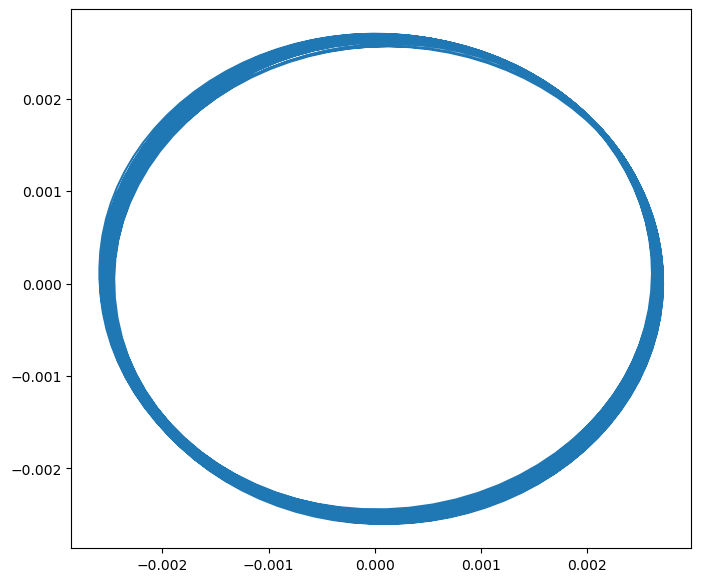

In [229]:
fig,axis=plt.subplots(figsize=(8, 7))
axis.plot(solver.y[0], solver.y[1], label='x')